In [3]:
# import required packages
# from fastai.tabular.all import *
# from matplotlib import style
import sys

import pandas as pd
import numpy as np
from pathlib import Path

sys.path.append('..')
from fpl_predictor.util import *

In [4]:
# path to project directory
path = Path('../')

In [5]:
# read in training dataset
train_df = pd.read_csv(path/'fpl_predictor/data/train_v8.csv', 
                       index_col=0, 
                       dtype={'season':str,
                              'squad':str,
                              'comp':str})

## Neural network model

Fastai have useful a neural network architecture that can be applied to tabular data, including for time series. In practice this creates embeddings for categorical features, combines them with continuous variables and passes this through a number of fully connected layers to produce a prediction for the dependent variable. They also include a number of tricks and default parameters that should produce decent performance.

Lag features are not strictly necessary for this approach since the embeddings should in some way be relating performance for recent weeks. In practice this seems to be confirmed in that adding the lag features does not appear to improve performance. However, we'll still create some features to remain consistent in the steps we take in all of these notebooks.

In [6]:
# add a bunch of lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

Again we set the variables to be used, the validation conditions, and order of some categorical features. We also need to set our dependent variable, total_points, to be a floating point number since this is the data type that fastai requires for a regression model.

In [18]:
# set validaton point/length and categorical/continuous variables
valid_season = '2021'
valid_gw = 20
valid_len = 6
cat_vars = ['gw', 'season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['minutes', 'relative_market_value_team_season', 'relative_market_value_opponent_team_season']
dep_var = ['total_points']

In [19]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920', '2021']

In [20]:
# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [21]:
# dependent variable needs to be float
lag_train_df['total_points'] = lag_train_df['total_points'].astype('float64')

In [54]:
# create dataset with adjusted post-validation lag numbers
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

train_valid_df[player_lag_vars + team_lag_vars] = train_valid_df[player_lag_vars + team_lag_vars].fillna(0)

In [55]:
# take a look at the dataframe
train_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82054 entries, 0 to 82053
Data columns (total 39 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   gw                                          82054 non-null  category
 1   minutes                                     82054 non-null  int64   
 2   minutes_last_1                              82054 non-null  float64 
 3   minutes_last_10                             82054 non-null  float64 
 4   minutes_last_2                              82054 non-null  float64 
 5   minutes_last_3                              82054 non-null  float64 
 6   minutes_last_4                              82054 non-null  float64 
 7   minutes_last_5                              82054 non-null  float64 
 8   minutes_last_all                            82054 non-null  float64 
 9   opponent_team                               82054 non-null  object  
 10

In [56]:
# need to remove 0 minute rows from the validation set
train_valid_df = pd.concat([train_valid_df.loc[train_idx],
                            train_valid_df.loc[valid_idx][train_valid_df.loc[valid_idx]['minutes'] > 0]],
                           ignore_index=True)

In [65]:
# and redo the valid indexes
valid_idx = range(valid_idx[0], train_valid_df.index.max() + 1)

We need to create a couple of lists with indexes for the training and validation sets - this can then be passed into the learner object which will handle training and validation automatically.

In [66]:
# create train/valid splits
splits = (list(train_idx), list(valid_idx))
valid_idx

range(78390, 80050)

A key difference with this approach is that we will be learning embeddings for all the categorical variables, including players. So, for example, we will learn a vector of numbers for each player that represents them. In theory, this negates the need for the kind of feature engineering that, for example, we are doing when calculating lagging features.

In previous approaches we did not use the player as a categorical feature, there were simply too many of them. So we will need to add this feature in, which we can do by simply adding them to the list of categorical features.

We can also have a quick look at how many levels there are for each of the categories - the fastai learner creates a default length for each of these variables based on the number of levels (but note that this default can be changed if so desired).

In [72]:
train_valid_df[cat_vars + ['player']].nunique()

gw                 38
season              4
position            4
team               29
opponent_team      29
was_home            2
player           1251
dtype: int64

In [73]:
cat_vars + ['player']

['gw', 'season', 'position', 'team', 'opponent_team', 'was_home', 'player']

Now we can instantiate our tabular object, including processors to handle some transformations we need to apply (handling the categorical features and normalising continuous variables to have a mean and standard deviation that help training). 

In [74]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]
to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                      splits=splits, y_names=dep_var)

The fastai requires us to create dataloaders that will then be used for training. We can do this and then take a look at one batch.

In [75]:
# dls = to_nn.dataloaders()
dls = to_nn.dataloaders()

In [76]:
dls.show_batch()

,gw,season,position,team,opponent_team,was_home,player,minutes,relative_market_value_team_season,relative_market_value_opponent_team_season,total_points
0,1,1617,1,Crystal Palace,West Bromwich Albion,True,Wayne Hennessey,9.000000e+01,0.802197,0.428062,2.0
1,33,1718,3,Stoke City,Tottenham Hotspur,True,Glenn Whelan,9.239857e-07,0.581587,1.751141,0.0
2,17,1718,3,Liverpool,West Bromwich Albion,True,Philippe Coutinho,9.000000e+01,1.619155,0.541354,3.0
3,36,1617,3,Manchester City,Crystal Palace,True,Ilkay Gündogan,9.239857e-07,2.311012,0.802197,0.0
4,30,1617,4,Swansea City,Middlesbrough,True,Modou Barrow,9.239857e-07,0.509881,0.452793,0.0
5,22,1819,1,Brighton and Hove Albion,Liverpool,True,Mathew Ryan,9.239857e-07,0.417745,2.177887,0.0
6,4,1718,2,Leicester City,Chelsea,True,Aleksandar Dragovic,9.239857e-07,0.824624,2.125018,0.0
7,35,1617,3,West Bromwich Albion,Leicester City,True,Rekeem Harper,9.239857e-07,0.428062,0.650832,0.0
8,13,1718,1,Everton,Southampton,False,Maarten Stekelenburg,9.239857e-07,1.134226,0.809578,0.0
9,23,1617,2,Bournemouth,Crystal Palace,True,Simon Francis,9.000000e+01,0.384921,0.802197,1.0


We also need to provide the range of output points that we expect - we set these to the highest score recorded in history at the upper end, and -1 at the lower end.

In [77]:
# set range of predictions - minimum to current max
max_y = np.max(lag_train_df['total_points'])
min_y = np.min(lag_train_df['total_points'])
y_range = (-1, max_y)

Now we can instatiate the learner and use the learning rate finder to get a feel for the best learning rate to use during training.

In [78]:
# learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
#                         n_out=1, loss_func=F.mse_loss, metrics=rmse)

learn = tabular_learner(dls, y_range=y_range, layers=[500,250], ps=[0.001,0.01], emb_drop=0.04,
                        n_out=1, loss_func=F.mse_loss, metrics=rmse)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0005754399462603033)

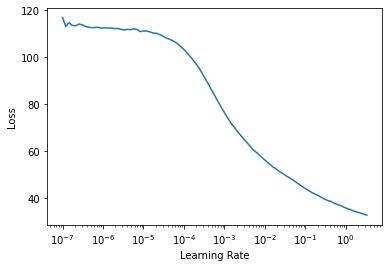

In [48]:
learn.lr_find()

Finally, we can fit the training data using one cycle learning and look at the performance.

In [ ]:
# seems to work ok without the lag vars
# learn.fit_one_cycle(7, 1e-2, wd=0.2) current approach
# learn.fit_one_cycle(5, 5e-3, wd=0.2)
# learn.fit_one_cycle(5, 5e-3, wd=0.2)

In [79]:
# [500, 250]
learn.fit_one_cycle(5, 5e-3, wd=0.2)
learn.fit_one_cycle(5, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,4.572065,9.231995,3.038419,00:29
1,3.477101,7.377028,2.716069,00:30
2,3.408481,7.198166,2.682940,00:31
3,3.141598,7.193734,2.682114,00:32
4,3.163087,7.237597,2.690278,00:30


epoch,train_loss,valid_loss,_rmse,time
0,3.611714,7.462976,2.731845,00:31
1,3.324669,7.683556,2.771923,00:31
2,3.392042,7.254427,2.693404,00:31
3,3.307658,7.220691,2.687135,00:31
4,3.165324,7.150162,2.673979,00:31


In [80]:
# check that rmse matches the training output above
preds,targs = learn.get_preds()
r_mse(preds,targs)

2.673979

get_preds() returns tensors which don't work for our existing mean absolute error function, so we'll create a slightly different function that works in this case.

In [82]:
def mae_tensor(pred,y): return round((abs(pred-y)).mean().item(), 6)

In [83]:
mae_tensor(preds,targs)

1.887987

Perhaps a little worse than XGBoost an Random Forest, so let's go ahead and run it across the whole season it see if that is consistently the case.

In [84]:
def nn_season(df, valid_season='1920'):

    # empty list for scores
    scores = []
    valid_len = 6

    # set limits
    max_y = np.max(df['total_points'])
    min_y = np.min(df['total_points'])
    y_range = (-1, max_y)

    for valid_gw in range(1,34): 

        train_valid_df, train_idx, valid_idx = create_lag_train(df, cat_vars, cont_vars, 
                                                        player_lag_vars, team_lag_vars, dep_var,
                                                        valid_season, valid_gw, valid_len)

        X, y = train_valid_df[cat_vars + cont_vars + player_lag_vars + team_lag_vars].copy(), train_valid_df[dep_var].copy()

        # need to remove 0 minute rows from the validation set
        train_valid_df = pd.concat([train_valid_df.loc[train_idx],
                                    train_valid_df.loc[valid_idx][train_valid_df.loc[valid_idx]['minutes'] > 0]],
                                   ignore_index=True)
        
        # and redo the valid indexes
        valid_idx = range(valid_idx[0], train_valid_df.index.max() + 1)
        
        # create train/valid splits
        splits = (list(train_idx), list(valid_idx))

        # processors - categorify categorical variables and normalize continuous variables
        # fill missing not used because new teams are almost certainly well below the league average
        procs=[Categorify, Normalize]
        to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                              splits=splits, y_names=dep_var)

        dls = to_nn.dataloaders()

#         learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
#                             n_out=1, loss_func=F.mse_loss, metrics=rmse)
        learn = tabular_learner(dls, y_range=y_range, layers=[500,250], ps=[0.001,0.01], emb_drop=0.04,
                            n_out=1, loss_func=F.mse_loss, metrics=rmse)


        # seems to work ok without the lag vars
        with learn.no_bar() and learn.no_logging():
#             learn.fit_one_cycle(7, 1e-2, wd=0.2, verbose=False)
            learn.fit_one_cycle(5, 5e-3, wd=0.2)
            learn.fit_one_cycle(5, 5e-3, wd=0.2)

        preds,targs = learn.get_preds()
        gw_mae = mae_tensor(preds,targs)

        print("GW%d MAE: %f" % (valid_gw, gw_mae))

        scores.append(gw_mae)
        
    return scores

In [85]:
scores = nn_season(lag_train_df)

GW1 MAE: 1.956985


GW2 MAE: 1.869431


GW3 MAE: 1.993806


GW4 MAE: 1.908115


GW5 MAE: 1.952784


GW6 MAE: 1.958072


GW7 MAE: 1.926290


GW8 MAE: 1.974809


GW9 MAE: 1.901531


GW10 MAE: 1.967511


GW11 MAE: 1.927523


GW12 MAE: 1.912230


GW13 MAE: 1.935655


GW14 MAE: 1.937519


GW15 MAE: 1.876396


GW16 MAE: 1.875604


GW17 MAE: 1.901559


GW18 MAE: 1.859086


GW19 MAE: 1.847051


GW20 MAE: 1.875914


GW21 MAE: 1.923851


GW22 MAE: 1.873930


GW23 MAE: 1.912922


GW24 MAE: 1.903462


GW25 MAE: 1.944220


GW26 MAE: 1.838577


GW27 MAE: 1.836599


GW28 MAE: 1.848797


GW29 MAE: 1.811418


GW30 MAE: 1.850501


GW31 MAE: 1.818086


GW32 MAE: 1.838819


GW33 MAE: 1.814780


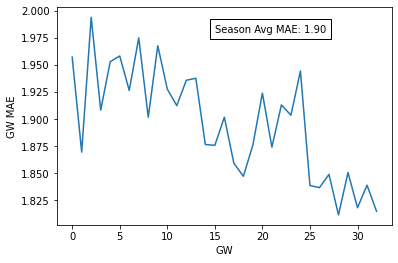

In [88]:
plt.plot(scores)
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 1.98, 'Season Avg MAE: %.2f' % np.mean(scores), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

The performance does appear to be consistently worse across the season than XGBoost, although it still outperforms the baseline model by a significant margin, as well as random forest. In practice it may be that playing around with the model architecture, hyperparameters and feature selection could still improve performance.

Another challenge is that performance varies when repeating the training using the same data - this non-deterministic behaviour is not necessarily a big issue, but it can raise questions from users when they see seemingly unexplainable differences in player forecasts from week to week (or within week if retraining is performed for some reason).

Let's add this final model to our scores dataset.

In [89]:
model_validation_scores = pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0)
model_validation_scores['neural_net'] = scores
model_validation_scores.to_csv(path/'charts/model_validation_scores.csv')

In [90]:
# sort scores by reverse overall mean score
model_validation_scores = model_validation_scores.reindex(model_validation_scores.mean()
                                                          .sort_values().index[::-1],
                                                          axis=1)

In [91]:
style.use('fivethirtyeight')

And we can create a chart comparing all four approaches.

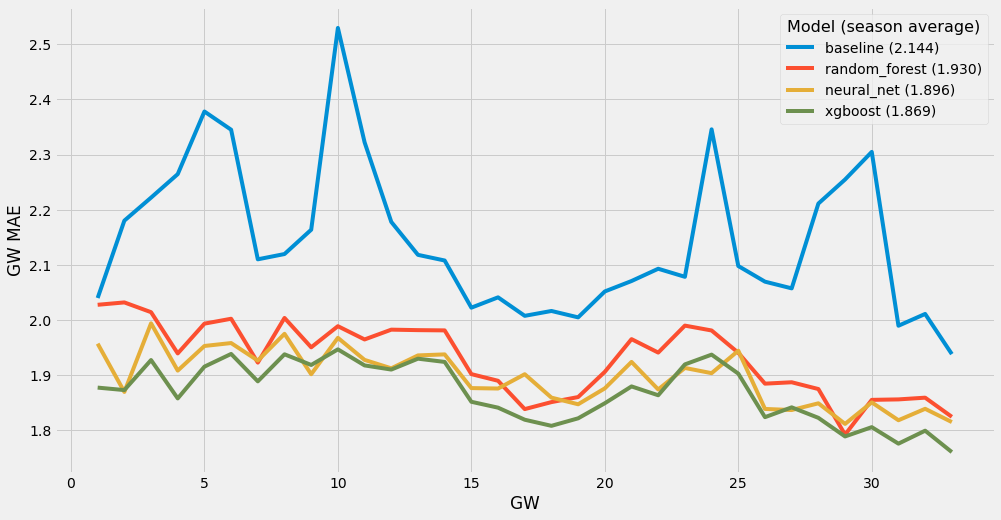

In [92]:
fig = plt.figure(figsize=(15, 8))

plt.plot(model_validation_scores)

legend_text = ['%s (%.3f)' %(model_validation_scores.columns[x], 
                             np.mean(model_validation_scores.iloc[:,x])) for x in range(4)]

plt.legend(legend_text, title='Model (season average)', title_fontsize='16')
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.show()

fig.savefig(path/'charts/comparison_chart.png')

So, based on performance and consistency, we will be using the XGBoost approach for our actual weekly forecasts. 